# **Restaurant Recommendation System**

1) We are using Yelp [data](https://www.kaggle.com/datasets/mobasshir/yelpdata?select=yelp_business.csv)

2) Import the csv as a dataframe 

3) get only the restaurants 

4) Group by city and view the data 

5) Select the city which has high amount of data 

6) Show top 20 restaurants in a map for the selected city

7) Find the value of K using the elbow method 

8) Show the groups found in the map 

9) Create a predict function which takes latitude and longitude as an example

In [ ]:
!pip install plotly_express

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import plotly_express as px
import numpy as np

# **Get the Yelp Data**

**Import the CSV as a dataframe**

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d mobasshir/yelpdata
!unzip yelpdata

100% 301M/302M [00:09<00:00, 30.3MB/s]
100% 302M/302M [00:09<00:00, 33.2MB/s]
Archive:  yelpdata.zip
  inflating: yelp_business.csv       
  inflating: yelp_recommendation_model_5.pkl  
  inflating: yelp_review_arizona.csv  


# **ETL**

In [7]:
df_raw = pd.read_csv('/content/yelp_business.csv')
df_raw.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,NaN,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


**Let's filter and get only the restaurants**

In [25]:
df_raw['Restaurants'] = df_raw['categories'].str.contains('Restaurants')
df_raw = df_raw.loc[df_raw.Restaurants == True]
df_raw.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",True
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",True


**Group by city and show as a bar graph , we select that city which has highest number of hotels**

We select Toronto as our preferred city as shown in the data

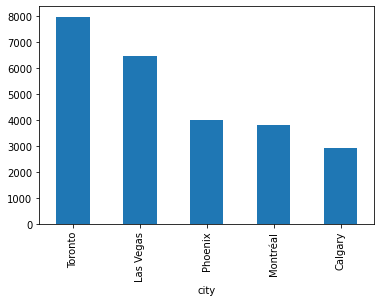

In [26]:
group = df_raw.groupby('city').size()
top_5_cities=group.sort_values(ascending=False).head(5)
top_5_cities.plot.bar()

**Select only hotels in Toronto**

In [27]:
df_raw['Is_Toronto'] = df_raw['city'].str.contains('Toronto')
df_raw = df_raw.loc[df_raw.Is_Toronto == True]
df_raw.head(2)

<ipython-input-27-e41aa74b9aed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Is_Toronto'] = df_raw['city'].str.contains('Toronto')


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,Is_Toronto
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",True,True
32,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",True,True


In [28]:
#This shape must be same as the baw graph as generated above 
df_raw.shape

(7966, 16)

**Sort the dataframe by rating and stars**

In [29]:
top_restaurants = df_raw.sort_values(by=['review_count', 'stars'], ascending=False)[:20]
top_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,Is_Toronto
127052,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,18 Duncan Street,Toronto,ON,M5H 3G8,43.647866,-79.388642,4.5,2121,1,"{'Ambience': ""{'romantic': False, 'intimate': ...","Restaurants, Food, Thai, Ethnic Food, Specialt...","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",True,True
162816,aLcFhMe6DDJ430zelCpd2A,Khao San Road,11 Charlotte Street,Toronto,ON,M5V 2H5,43.646411,-79.393480,4.0,1410,1,"{'OutdoorSeating': 'False', 'BikeParking': 'Tr...","Thai, Restaurants","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",True,True
178425,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,398 Church St,Toronto,ON,M5B 2A2,43.660430,-79.378927,4.0,1397,1,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Bars, Restaurants, Japanese, Tapas/Small Plate...","{'Monday': '17:0-0:0', 'Tuesday': '17:0-0:0', ...",True,True
114931,iGEvDk6hsizigmXhDKs2Vg,Seven Lives Tacos Y Mariscos,69 Kensington Avenue,Toronto,ON,M5T 2K2,43.654341,-79.400480,4.5,1152,1,"{'NoiseLevel': ""u'average'"", 'RestaurantsDeliv...","Seafood, Restaurants, Mexican","{'Monday': '12:0-20:0', 'Tuesday': '12:0-20:0'...",True,True
99903,N93EYZy9R0sdlEvubu94ig,Banh Mi Boys,392 Queen Street W,Toronto,ON,M5V 2A9,43.648827,-79.396970,4.5,1045,1,"{'NoiseLevel': ""u'average'"", 'Ambience': ""{'ro...","Sandwiches, Restaurants, Asian Fusion, Food, D...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",True,True


**Get distribution of the rating**

We see many restaurants have rating between 3 to 4

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


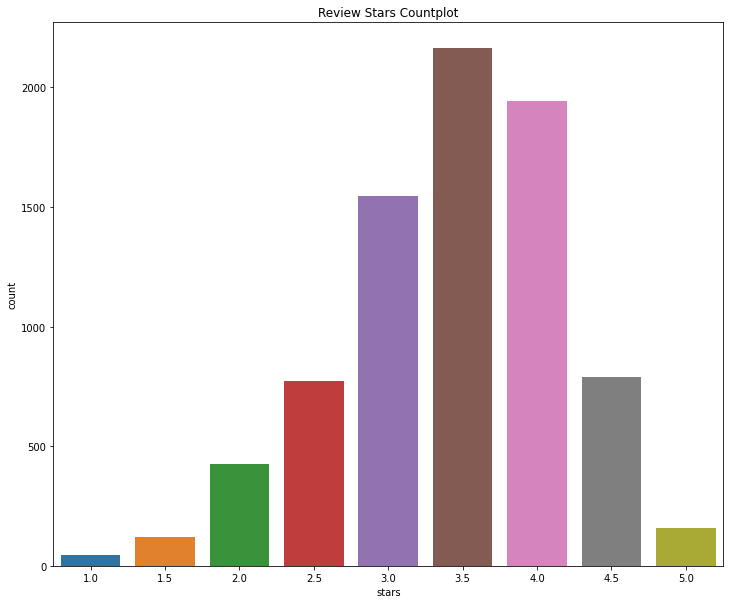

In [31]:
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(df_raw['stars'], ax=ax)
plt.title('Review Stars Countplot')
plt.show()

In [32]:
toronto = df_raw

# **Model Creation**

**Find the value of K using the elbow method**

Also refer to the 
https://en.wikipedia.org/wiki/List_of_municipalities_in_the_Greater_Toronto_Area , we see ~25 sub divisions , so we also try the silhouette_score method

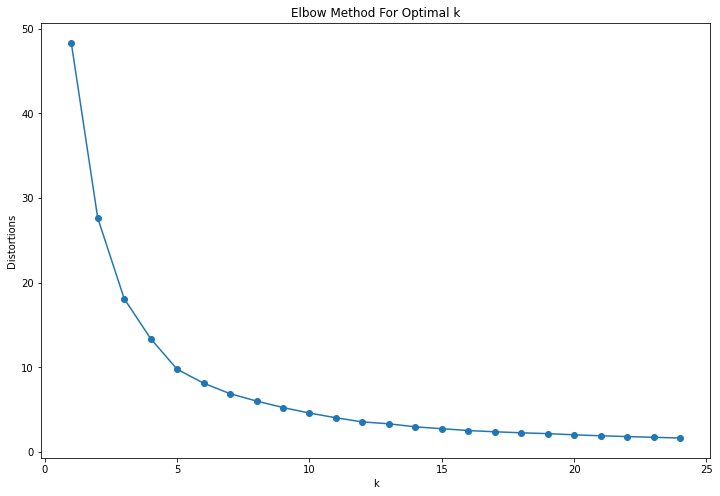

In [34]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = toronto[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

**Silhoute method**

In [35]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))
sil

[0.5483238084897126,
 0.5019578559257404,
 0.5254840296604718,
 0.5006372943452357,
 0.45067170237149895,
 0.4517152810861254,
 0.4643159428230584,
 0.4607046883107144,
 0.4644041957052111,
 0.4304340357104877,
 0.4398602384343006,
 0.4388166750806552,
 0.4412061459473896,
 0.4200789035435967,
 0.4225553390987674,
 0.4088624990752376,
 0.4118579999712929,
 0.4161368406628748,
 0.4134427318663699,
 0.42211321702949794,
 0.42418964735760073,
 0.4175641665763241,
 0.43022108307531626,
 0.4268463544218682,
 0.4148032499590187,
 0.42351064003118194,
 0.41149715915725976,
 0.42639054547352584,
 0.41576967644811624,
 0.4241978122519655,
 0.42206063116993997,
 0.4174256757153959,
 0.4245003289845454,
 0.4212624552159612,
 0.4333364089725829,
 0.41543888554685793,
 0.40312842306272934,
 0.41155999830226814,
 0.4138787964560757,
 0.42613162265886195,
 0.4045774252189058,
 0.4267223876314563,
 0.4104626426565317,
 0.4135758908494817,
 0.4192182713737314,
 0.4152459681680487,
 0.4231777420737999,


In [36]:
len(sil)

49

**Train the K Means model**

In [37]:
kmeans = KMeans(n_clusters=len(sil), init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_

In [38]:
toronto['cluster'] = kmeans.predict(toronto[['longitude','latitude']])
toronto.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,Is_Toronto,cluster
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,1,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",True,True,22
32,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,0,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...",True,True,41
50,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,0,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ...","{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...",True,True,7
83,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,619 Mount Pleasant Road,Toronto,ON,M4S 2M5,43.704229,-79.388230,4.0,18,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'Fals...","Italian, Restaurants",NaN,True,True,25
96,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,1614 Queen Street E,Toronto,ON,M4L 1G4,43.666181,-79.316468,3.5,43,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Tex-Mex, Mexican, Restaurants","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",True,True,38


**Show the groups found in the map**

We segregated toronto into 49 groups/suburbs as per the data

In [46]:
px.set_mapbox_access_token("<Add your mapbox token here>")
px.scatter_mapbox(toronto, lat="latitude", lon="longitude", color="cluster", size='review_count', hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1200, height=800)

# **Predict**

**Create a predict function which takes langitude and latidude and sorts by rating and reviews count**

In [65]:
length = len(toronto)

def recommend_restaurants(df, longitude, latitude,count=20):
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    if length<count:
      count = len(top_restaurants)
    df= df[df['cluster']==cluster].iloc[0:count][['name', 'latitude','longitude','review_count','stars']]
    top_restaurants = df.sort_values(by=['review_count', 'stars'], ascending=False)
    return top_restaurants

In [66]:
top_3_places_in_toronto = [
    [-79.393040,43.670749], #Yorkville
    [-79.377,43.691], # Rosedale/Summerhill/Moore Park
    [-79.38704,43.64726] #Fashion District/Entertainment District
]

**Top 20 restaurants near Yorkville**

In [74]:
result = recommend_restaurants(toronto,top_3_places_in_toronto[0][0],top_3_places_in_toronto[0][1],count=20)
px.scatter_mapbox(result, lat="latitude", lon="longitude", size='review_count', hover_data= ['name', 'latitude', 'longitude'], zoom=15, width=1200, height=800)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [75]:
result.head()

,name,latitude,longitude,review_count,stars
1136,O.Noir,43.669121,-79.382764,301,3.5
9814,Como En Casa,43.665339,-79.384500,196,4.0
7538,Dimmi Bar & Trattoria,43.670094,-79.392677,171,3.5
2126,Buca Yorkville,43.672142,-79.389392,158,3.5
6034,OverEasy Restaurant,43.668659,-79.395839,149,3.0


**Top 20 restaurants near Moore Park**

In [76]:
result = recommend_restaurants(toronto,top_3_places_in_toronto[1][0],top_3_places_in_toronto[1][1],count=20)
px.scatter_mapbox(result, lat="latitude", lon="longitude", size='review_count', hover_data= ['name', 'latitude', 'longitude'], zoom=15, width=1200, height=800)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [77]:
result.head()

,name,latitude,longitude,review_count,stars
18874,Mt Everest Restaurant,43.713414,-79.366641,76,3.5
31776,Maki Sushi,43.710378,-79.363418,51,3.0
32209,North Shore Pie,43.713540,-79.364984,34,4.0
22404,Five Guys,43.705616,-79.361144,27,3.0
22924,Sunset Grill,43.710300,-79.363142,25,3.5


**Top 20 Restaurants near Entertainment District**

In [78]:
result = recommend_restaurants(toronto,top_3_places_in_toronto[2][0],top_3_places_in_toronto[2][1],count=20)
px.scatter_mapbox(result, lat="latitude", lon="longitude", size='review_count', hover_data= ['name', 'latitude', 'longitude'], zoom=15, width=1200, height=800)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [79]:
result.head()

,name,latitude,longitude,review_count,stars
159,Ravi Soups,43.647585,-79.392032,332,4.5
987,Le Gourmand,43.648123,-79.396641,214,4.0
3813,Luckee,43.644697,-79.392395,186,3.5
5946,Fred's Not Here,43.646116,-79.390797,182,3.0
5508,Town Crier Pub,43.648143,-79.390151,181,4.0
